# [NTDS'18] milestone 3: spectral graph theory
[ntds'18]: https://github.com/mdeff/ntds_2018

[Michaël Defferrard](http://deff.ch), [EPFL LTS2](https://lts2.epfl.ch)

## Students

* Team: `32`
* Students: `George Adaimi, Okan Altingovde, Isinsu Katircioglu, Sena Kiciroglu`
* Dataset: `FMA`

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The goal of this milestone is to get familiar with the graph Laplacian and its spectral decomposition.

## 0 Load your network

In [35]:
%matplotlib inline

If you get a `No module named 'sklearn'` error when running the below cell, install [scikit-learn](https://scikit-learn.org) with `conda install scikit-learn` (after activating the `ntds_2018` environment).

In [36]:
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
#from sklearn.cluster import KMeans

Let's denote your graph as $\mathcal{G} = (\mathcal{V}, \mathcal{E}, A)$, where $\mathcal{V}$ is the set of nodes, $\mathcal{E}$ is the set of edges, $A \in \mathbb{R}^{N \times N}$ is the (weighted) adjacency matrix, and $N = |\mathcal{V}|$ is the number of nodes.

Import the adjacency matrix $A$ that you constructed in the first milestone.
(You're allowed to update it between milestones if you want to.)

In [37]:
#adjacency =  np.load('adjacency.npy')# the adjacency matrix
adjacency =  np.load('adjacency_noDisconnectedNodes_mfccStdMean.npy')
n_nodes =  adjacency.shape[0]# the number of nodes in the network
n_edges =  np.count_nonzero(adjacency)//2# the number of edges in the network
print('Number of nodes: ', n_nodes)
print('Number of edges: ', n_edges)

Number of nodes:  2000
Number of edges:  600104


## 1 Graph Laplacian

### Question 1

From the (weighted) adjacency matrix $A$, compute both the combinatorial (also called unnormalized) and the normalized graph Laplacian matrices.

Note: if your graph is weighted, use the weighted adjacency matrix. If not, use the binary adjacency matrix.

For efficient storage and computation, store these sparse matrices in a [compressed sparse row (CSR) format](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_.28CSR.2C_CRS_or_Yale_format.29).

In [165]:
D = np.diag(adjacency.sum(axis=1))
L = D - adjacency
laplacian_combinatorial =  sparse.csr_matrix(L)

sqrt_D = np.power(np.linalg.inv(D),0.5)
laplacian_normalized = sparse.csr_matrix(sqrt_D@L@sqrt_D)


[27.13690964 29.63160625  3.59797523 ... 20.97804569  8.29116834
  7.5893558 ]
[[-0.00115555  0.00036453]
 [-0.0011558   0.00036504]
 [-0.00116064  0.00037516]
 ...
 [-0.00115634  0.00036613]
 [-0.00115849  0.00037051]
 [-0.00115846  0.00037044]]
###########
[[-0.00115555 -0.00036453]
 [-0.0011558  -0.00036504]
 [-0.00116064 -0.00037516]
 ...
 [-0.00115634 -0.00036613]
 [-0.00115849 -0.00037051]
 [-0.00115846 -0.00037044]]


Use one of them as the graph Laplacian $L$ for the rest of the milestone.
We however encourage you to run the code with both to get a sense of the difference!

In [74]:
laplacian =  laplacian_normalized

### Question 2

Compute the eigendecomposition of the Laplacian $L = U^\top \Lambda U$, where the columns $u_k \in \mathbb{R}^N$ of $U = [u_1, \dots, u_N] \in \mathbb{R}^{N \times N}$ are the eigenvectors and the diagonal elements $\lambda_k = \Lambda_{kk}$ are the corresponding eigenvalues.

Make sure that the eigenvalues are ordered, i.e., $0 = \lambda_1 \leq \lambda_2 \leq \dots \leq \lambda_N$.

In [75]:
eigenvalues, eigenvectors = np.linalg.eig(laplacian.todense())

assert eigenvectors.shape == (n_nodes, n_nodes)

## Sorting Eigenvalues and EigenVectors
sorted_indexes = eigenvalues.argsort()
eigenvalues = eigenvalues[sorted_indexes]
eigenvectors = eigenvectors[sorted_indexes]

Justify your choice of eigensolver.

**Our answer here.**
We choose numpy's eigensolver since we want to compute eigenvalues for all eigenvectors which is not possible with scipy sparse eigensolver.

### Question 3

We can write $L = S S^\top$. What is the matrix $S$? What does $S^\top x$, with $x \in \mathbb{R}^N$, compute?

**Your answer here.** If L is the unnormalized laplacian, then S is the incidence matrix with its elements:

$$S(i,j) = \left\{\begin{matrix}
 +1& \text{if } e_j=(v_i,v_k) \text{ for some } k \\ 
 -1& \text{if } e_j=(v_k,v_i) \text{ for some } k\\ 
 0& otherwise
\end{matrix}\right.$$

On the other hand, if L is normalized, then S is the matrix where:

$$S(i,j) = \left\{\begin{matrix}
 +\frac{1}{\sqrt{d_u}}& \text{if } e_j=(v_i,v_k) \text{ for some } k \\ 
 -\frac{1}{\sqrt{d_u}}& \text{if } e_j=(v_k,v_i) \text{ for some } k\\ 
 0& otherwise
\end{matrix}\right.$$

where $d_v$ and $d_u$ denote the degree of the vertex v and u respectively.

$S^Tx$ computes the eigenvectors of S. (The derivative?????)

### Question 4

Show that $\lambda_k = \| S^\top u_k \|_2^2$, where $\| \cdot \|_2^2$ denotes the squared Euclidean norm (a.k.a. squared $L^2$ norm).

**Your answer here.**

What does the quantity $\| S^\top x \|_2^2$ tell us about $x$?

**Your answer here.**

### Question 5

What is the value of $u_0$, both for the combinatorial and normalized Laplacians?

In [104]:
eigenvalues_c, eigenvectors_c = np.linalg.eig(laplacian_combinatorial.todense())
sorted_indexes_c = eigenvalues_c.argsort()
eigenvalues_c = eigenvalues_c[sorted_indexes_c]
eigenvectors_c = eigenvectors_c[sorted_indexes_c]

/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


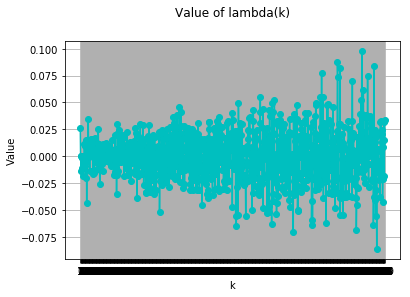

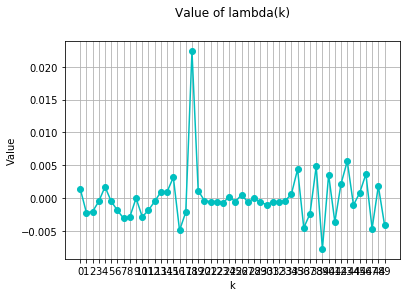

Norm: 1.859380572954172
Comb: 1129.5051562423555


In [111]:
u0_n = np.squeeze(np.asarray(eigenvectors[0]))
u0_c = np.squeeze(np.asarray(eigenvectors_c[0]))


def plot_spectrum(eigenvalues,with_label,range = None):
    eigenvalues = eigenvalues[:None]
    fig = plt.figure()
    index = np.arange(len(eigenvalues))
    ax = fig.add_subplot(1,1,1)
    #ax.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(index, eigenvalues, label='eingenvalues', color='c', marker='o')
    ax.set_ylabel('Value')
    plt.xticks(index)
    #plt.ylabel('Value')
    plt.xlabel('k')
    ax.grid('on')
    
    if with_label:
        for x, eigenvalue in zip(index,eigenvalues):
            ax.annotate('%.2f'%(eigenvalue), (x,eigenvalue))
    plt.title('Value of lambda(k)', pad=25)
    plt.show()
    plt.close(fig)
    
plot_spectrum(u0[:1000],with_label=False)
plot_spectrum(u0_c[:50],with_label=False)

print('Norm: {}'.format(eigenvalues[-1]))
print('Comb: {}'.format(eigenvalues_c[-1]))

#eigenvectors[0]

**Your annswer here.**

### Question 6

Look at the spectrum of the Laplacian by plotting the eigenvalues.
Comment on what you observe.

/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


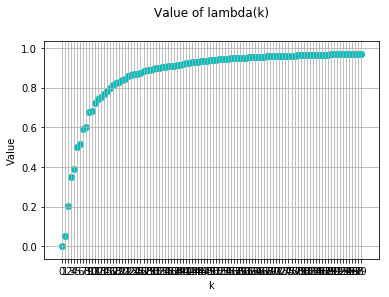

In [118]:
# Your code here.
#0th eigenval should be 0

def plot_spectrum(eigenvalues,with_label,scatter = False,range = None):
    eigenvalues = eigenvalues[:None]
    fig = plt.figure()
    index = np.arange(len(eigenvalues))
    ax = fig.add_subplot(1,1,1)
    ax.set_facecolor((1.0, 1.0, 1.0))

    ax.set_ylabel('Value')
    plt.xticks(index)
    #plt.ylabel('Value')
    plt.xlabel('k')
    ax.grid('on')

    if with_label:
        for x, eigenvalue in zip(index,eigenvalues):
            ax.annotate('%.2f'%(eigenvalue), (x,eigenvalue))
    if not scatter:
        plt.plot(index, eigenvalues, label='eingenvalues', color='c', marker='o')  
    else:
        plt.scatter(index, eigenvalues, label='eingenvalues', color='c', marker='o')
    plt.title('Value of lambda(k)', pad=25)
    plt.show()
    plt.close(fig)
        
plot_spectrum(eigenvalues[:100],scatter=True, with_label=False)   

**Our answer:**
* The smallest eigenvalue is 0 and the next smallest eigenvalue is greater than 0. This shows that the multiplicity of 0 is 1, and we have only 1 connected component in our graph.
* The largest eigenvalue is less than 2.

How many connected components are there in your graph? Answer using the eigenvalues only.

In [121]:
# Your code here.
#we count the number of eigenvalues with value 0
def get_numbConnectedComp(eigenvalues):
    return np.sum(np.round(eigenvalues,decimals=2) == 0)

print("The number of connected components:", get_numbConnectedComp(eigenvalues))

The number of connected components: 1


Is there an upper bound on the eigenvalues, i.e., what is the largest possible eigenvalue? Answer for both the combinatorial and normalized Laplacians.

**Our answer:**
* The upperbound for the normalized Laplacian's largest eigenvalue is 2. It can be equal to 2 if and only if the graph is bipartite. 
* There is no upperbound for the combanitorial Laplacian's largest eigenvalue. **check**

## 3 Laplacian eigenmaps

*Laplacian eigenmaps* is a method to embed a graph $\mathcal{G}$ in a $d$-dimensional Euclidean space.
That is, it associates a vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$.
The graph $\mathcal{G}$ is thus embedded as $Z \in \mathbb{R}^{N \times d}$.

### Question 7

What do we use Laplacian eigenmaps for? (Or more generally, graph embeddings.)

**Your answer here.**
We use Laplacian eigenmaps to reduce the dimensionality of the graph. This allows us to process the graph more easily by reducing the dimension while not affecting how the nodes are clustered within the graph.


and to be able to process the graph itself.

### Question 8

Embed your graph in $d=2$ dimensions with Laplacian eigenmaps.
Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.

**Recompute** the eigenvectors you need with a partial eigendecomposition method for sparse matrices.
When $k \ll N$ eigenvectors are needed, partial eigendecompositions are much more efficient than complete eigendecompositions.
A partial eigendecomposition scales as $\Omega(k |\mathcal{E}|$), while a complete eigendecomposition costs $\mathcal{O}(N^3)$ operations.

In [183]:
# Your code here.

def get_LaplacianEigenMaps(laplacian, new_dim =2,use_normalized=True):
    eigenvalues, eigenvectors = sparse.linalg.eigsh(laplacian, which='SM', k=new_dim+1)
    embeddings = eigenvectors[:,1:new_dim+1]
    if use_normalized:
        return (embeddings.T*np.diag(sqrt_D)).T
    return embeddings

embeddings_c = get_LaplacianEigenMaps(laplacian_combinatorial,use_normalized=False)

embeddings_n = get_LaplacianEigenMaps(laplacian_normalized)


#### REMOVE:  Checking sklearn output
from sklearn.manifold import spectral_embedding

embeddings_n_sc = spectral_embedding(adjacency, n_components=2)
embeddings_c_sc = spectral_embedding(adjacency, n_components=2,norm_laplacian = False)

Plot the nodes embedded in 2D. Comment on what you see.

Shape of embedding_c: (2000, 2)
Shape of embedding_n: (2000, 2)


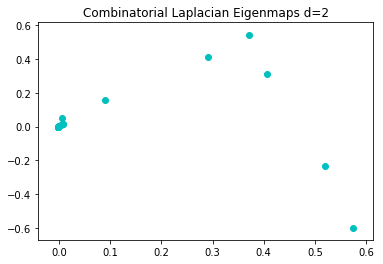

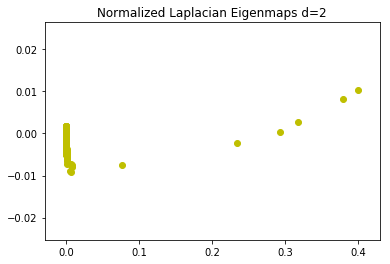

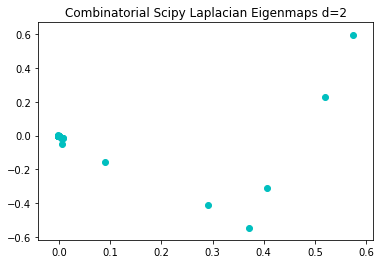

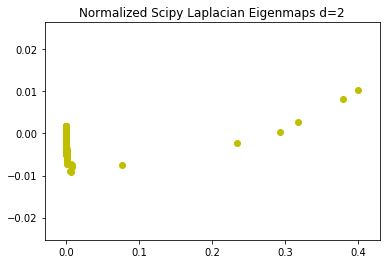

In [184]:
# Your code here.
print('Shape of embedding_c: {}'.format(embeddings_c.shape))
print('Shape of embedding_n: {}'.format(embeddings_n.shape))
fig = plt.figure()
plt.scatter(embeddings_c[:,0],embeddings_c[:,1], label='', color='c', marker='o')
plt.title('Combinatorial Laplacian Eigenmaps d=2')
plt.show()
plt.close(fig)

fig = plt.figure()
plt.scatter(embeddings_n[:,0],embeddings_n[:,1], label='', color='y', marker='o')
plt.title('Normalized Laplacian Eigenmaps d=2')
plt.show()
plt.close(fig)


##### REMOVE: Checking sklearn output
fig = plt.figure()
plt.scatter(embeddings_c_sc[:,0],embeddings_c_sc[:,1], label='', color='c', marker='o')
plt.title('Combinatorial Scipy Laplacian Eigenmaps d=2')
plt.show()
plt.close(fig)

fig = plt.figure()
plt.scatter(embeddings_n_sc[:,0],embeddings_n_sc[:,1], label='', color='y', marker='o')
plt.title('Normalized Scipy Laplacian Eigenmaps d=2')
plt.show()
plt.close(fig)

**Your answer here.**

### Question 9

What does the embedding $Z \in \mathbb{R}^{N \times d}$ preserve?

**Your answer here.**
* Preserves the relationship between nodes that is it keeps information about how nodes are clustered together. It does not ruin the locality of the nodes.

## 2 Spectral clustering

*Spectral clustering* is a method to partition a graph into distinct clusters.
The method associates a feature vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$, then runs [$k$-means](https://en.wikipedia.org/wiki/K-means_clustering) in the embedding space $\mathbb{R}^d$ to assign each node $v_i \in \mathcal{V}$ to a cluster $c_j \in \mathcal{C}$, where $k = |\mathcal{C}|$ is the number of desired clusters.

### Question 10

Choose $k$ and $d$. How did you get to those numbers?

**Our answer**
* k=2 because we are using the small version of the FMA dataset which has 2 labels. 

### Question 11

1. Embed your graph in $\mathbb{R}^d$ as $Z \in \mathbb{R}^{N \times d}$.
   Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.
1. If you want $k=2$ clusters, partition with the Fiedler vector. For $k > 2$ clusters, run $k$-means on $Z$. Don't implement $k$-means, use the `KMeans` class imported from scikit-learn.

In [185]:
# Your code here.

embeddings_c_100 = get_LaplacianEigenMaps(laplacian_combinatorial, new_dim = 100, use_normalized=False)
embeddings_n_100 = get_LaplacianEigenMaps(laplacian_normalized, new_dim = 100)

_, temp = sparse.linalg.eigsh(embeddings_n_100, which='SM', k=2)
fiedler_vector = temp[:,1]


clusters = np.zeros([n_nodes,])
clusters[fiedler_vector>0] = 1
clusters[fiedler_vector<=0] = -1


fig = plt.figure()
plt.scatter(embeddings_c[clusters==1,0],embeddings_c[clusters==1,1], label='', color='r', marker='x')
plt.scatter(embeddings_c[clusters==-1,0],embeddings_c[clusters==-1,1], label='', color='y', marker='o')
plt.title('SKDHJLSKHDLJ')
plt.show()
plt.close(fig)


ValueError: expected square matrix (shape=(2000, 100))

### Question 12

Use the computed cluster assignment to reorder the adjacency matrix $A$.
What do you expect? What do you observe?

In [ ]:
# Your code here.

**Your answer here.**

### Question 13

If you have ground truth clusters for your dataset, compare the cluster assignment from spectral clustering to the ground truth.
A simple quantitative measure is to compute the percentage of nodes that have been correctly categorized.
If you don't have a ground truth, qualitatively assess the quality of the clustering.

Ground truth clusters are the "real clusters".
For example, the genre of musical tracks in FMA, the category of Wikipedia articles, the spammer status of individuals, etc.
Look for the `labels` in the [dataset descriptions](https://github.com/mdeff/ntds_2018/tree/master/projects/README.md).

In [ ]:
# Your code here.

### Question 14

Plot the cluster assignment (one color per cluster) on the 2D embedding you computed above with Laplacian eigenmaps.

In [ ]:
# Your code here.

### Question 15

Why did we use the eigenvectors of the graph Laplacian as features? Could we use other features for clustering?

**Your answer here.**